<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/TP1_Ale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
!pip install pandas


## Demanda electrica horaria, tratamiento para Series Temporales


In [133]:
#Importar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

Importamos la Serie

Como tenemos la serie en el Drive, tenemos que improtar una serie de librerias para poder levantar la serie

No olvidar dar los permisos al archivo para poder leer desde el jpynb el mismo.
Luego, copiamso la ruta al archivo, pero solo nos quedamos con el id para acceder al mismo, a continuacion se copia la ruta completa al archivo

https://drive.google.com/file/d/1cuyeVtIy_DOtiADp5cHwNsucJpzhaBqG/view?usp=share_link


Siempre que tenga que leer un archivo que esta en un drive, copiar esta ruta

In [134]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Air Pasangers
id = "1cuyeVtIy_DOtiADp5cHwNsucJpzhaBqG"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('DemHoraria_v2.csv')
data = pd.read_csv("DemHoraria_v2.csv", sep=",") # Cargamos el Dataset

In [135]:
data.head()

,data_hora,Demanda_MW,Vel_viento
0,2015-10-01 02,1032.75,29.90
1,2015-10-01 03,960.61,17.30
2,2015-10-01 04,938.91,8.71
3,2015-10-01 05,943.28,7.25
4,2015-10-01 06,977.78,16.47


In [136]:
# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)

In [137]:
result=type(data)
print(result)

<class 'pandas.core.frame.DataFrame'>


In [138]:
data.describe()

,Demanda_MW,Vel_viento
count,65535.00,65535.00
mean,2968922103603471429081759744.00,28572930498310260279209885696.00
std,730611400952401882395598389248.00,6903114358998181710542512586752.00
min,-555555.00,0.00
25%,1091.63,8.93
50%,1265.12,15.55
75%,1432.30,26.43
max,186877000000000019090986688839680.00,1763840000000000042999632019587072.00


En base a los valores anteriores, claramente hay datos atipicos en la base, en primer lugar no podemso tener valores negativos de demanda, vemos que el minimo es negativo y el maximo supera el pico de 2242 MW, todo lo que este fuera de este rango, son atipicos

Continuando con el analisis que hizo Andres
# Preprocesamiento

In [139]:
# Verificamos el Dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data_hora   65535 non-null  object 
 1   Demanda_MW  65535 non-null  float64
 2   Vel_viento  65535 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB
None


Se observan 65535 registros
No se obuservan nulos.

# Eliminamos la tercer columna.
(velocidad del viento, dado que no la vamos a utilizar)

In [140]:
data.drop(columns="Vel_viento", inplace=True)

In [141]:
# Convertimos la columna "data_hora" a tipo de datos de fecha y hora

data["data_hora"]= pd.to_datetime(data["data_hora"], format="%Y-%m-%d %H")

In [142]:
# Renombramos las variables
data.rename(columns={"Demanda_MW": "Demanda", "data_hora":"Fecha"}, inplace=True)

In [143]:
# Seteamos la Fecha como Index
data=data.set_index("Fecha")
display(data.head())

,Demanda
Fecha,
2015-10-01 02:00:00,1032.75
2015-10-01 03:00:00,960.61
2015-10-01 04:00:00,938.91
2015-10-01 05:00:00,943.28
2015-10-01 06:00:00,977.78


# Analizamos las variables de estudio "Demanda"

In [144]:
# Hacemos una descripcion del dataset
display(data.describe())

,Demanda
count,65535.00
mean,2968922103603471429081759744.00
std,730611400952401882395598389248.00
min,-555555.00
25%,1091.63
50%,1265.12
75%,1432.30
max,186877000000000019090986688839680.00


Como ya se indico, es necesario evaluar los valores atipicos, como es una demanda electrica lo que estamos analizando, no es posible tener valores negativos, no tiene sentido fisico. Segun el minimo que figura en el analisis anterior, tenemos valores negativos.
Por otro lado, el pico de demanda maxima en el periodo analizado es 2300MW, por lo tanto, todo valor superior es atipico.

En este periodo tenemos un solo valor "0", el cual es un dato real, fue el corte del 19 de junio de 2019, corte que afecto a Argentina, Brazil y Uruguay, el valor que sigue en minimo es de 83MW.

In [145]:
# En basea a lo antes expuesto, vemos en que fechas tenemos los errores. Cotas establecidas [83, 2300]
display(data.query("Demanda> 2300 or Demanda<83"))


,Demanda
Fecha,
2017-10-19 10:00:00,7691310000000000899886144815104.00
2017-10-19 11:00:00,186877000000000019090986688839680.00
2017-11-16 03:00:00,-555555.00
2017-11-20 03:00:00,-555555.00
2017-11-25 03:00:00,-555555.00
2018-03-20 10:00:00,2265329999999999934464.00
2018-03-20 11:00:00,43041200000000000524288.00
2018-03-20 12:00:00,3020450000000000196608.00
2018-03-21 16:00:00,11326499999999999344640.00


In [146]:
# # Calculamos la mediana general
# median_demand=data["Demanda"][data["Demanda"].between(83, 2300)].median()
# print("Mediana:", median_demand)

Si bien se plantea sustituir los valores extremos por la mediana, no es lo mas conveniente, dado que depende el momento del a;o y la hora donde esta el valor extremo, deberiamos sustituir el valor por el valor en la hora anterior o posterior al valor atipico. De todas formas, como ahora no se como hacerlo, continuo con el procedimiento que hizo Andres

In [147]:
# # Remplazo valores extremos y negativos por la media calculada
# data["Demanda"]= data["Demanda"].apply(lambda x:median_demand if x>2300 or x<83 else x)

Aca en lugar de reemplazar los valores fuera de rango por la Mediana general, primero los ponemos en Null, y luego aplicamos un Back-Fill

In [148]:
# Poniendo en nulos los valores menores a 83 o mayores a 2300
data['Demanda'] = data['Demanda'].apply(lambda x: x if (x >= 83 and x <= 2300) else None)

print('Cantidad de fuera de rango previa:', data.isnull().sum())

# Realizando backfill para llenar los valores nulos/fuera de rabgo
data['Demanda'].fillna(method='backfill', inplace=True)

print('Cantidad de fuera de rango post:', data.isnull().sum())

Cantidad de fuera de rango previa: Demanda    12
dtype: int64
Cantidad de fuera de rango post: Demanda    0
dtype: int64


In [149]:
# Hacemos otro describ para verificar la correccion de los errores
display(data.describe())

,Demanda
count,65535.00
mean,1275.34
std,240.78
min,86.86
25%,1091.63
50%,1265.07
75%,1432.20
max,2237.63


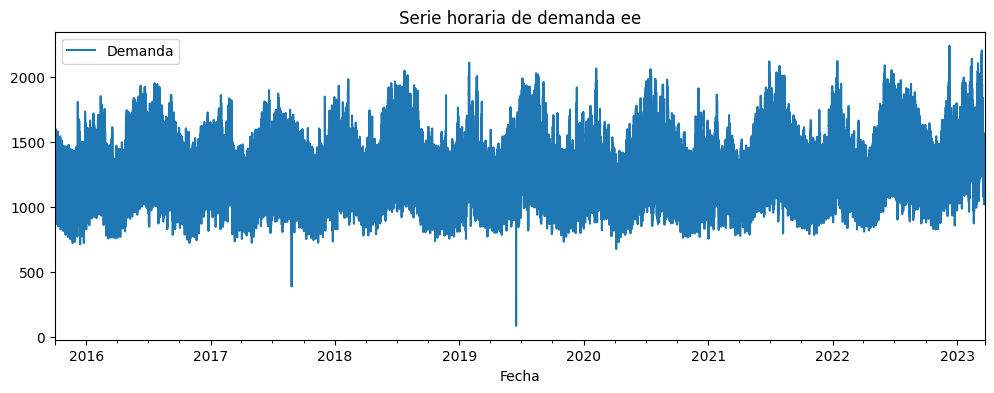

In [150]:
# Ploteamos para ver como queda la serie corregida
data.plot(title="Serie horaria de demanda ee", figsize=(12,4))
plt.show()

- Se siguen observando dos valores muy bajos, segurmente debamos modificar la cota inferior. Confirmarlo con Ale

Decidimos no agregar los valores por dia, y dejarlos atomizados por hora

In [ ]:
# # Dado que el corte po rhora es muy atomizado, agregamos por dia
# data_daily=data["Demanda"].resample("D").sum()
# data_daily.plot(title="Serie agregada por Dia de demanda ee", figsize=(12,4))
# plt.show()


In [ ]:
# # Seguimos con la variable data
# data=data_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo tranforma a Pandas Serie (No se porque se hizo este paso)

# Analisis de Estacionariedad